<a href="https://www.kaggle.com/victortrigo/cnn-para-diagnostico-de-neumon-a?scriptVersionId=85566663" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CNN Pneumonia

Autor: Víctor Trigo

¿Qué es la neumonía?

Las enfermedades respiratorias son el tercer lugar de las causas generales de muerte en Chile (según el Ministerio de Salud). La neumonía es una infección del tejido pulmonar, comúnmente encontrada en niños y adultos mayores a 65 años. El diagnostico de neumonia requiere principalmente de una radiografia de torax y de examenes fisicos. Mejorar nuestras habilidades de diagnostico es valioso y de gran valor para la medicina.

A continuación se construira una arquitectura de Redes neuronales convolucionales para predecir la presencia de neumonía a travez de radiografias de torax.

In [1]:
# Librerias

import tensorflow as tf                                                                                              # Backend de Keras
from tensorflow.keras import models, optimizers, regularizers                                                        # Componentes de un modelo
from tensorflow.keras.models import Sequential, load_model                                                           #
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization    # Capas del modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator                                                  # Aumentar tamaño del dataset
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping                                                # Puntos de guardado y detencion en el entrenamiento

import matplotlib.pyplot as plt    # Graficas
import numpy as np                 # Matematicas
import pandas as pd                # Dataframes

import cv2                         # Trabajar con directorios
import os                          #


import warnings                    # Manejo de Warnings
warnings.filterwarnings("ignore")

## ETL

Se creara una función llamada 'get_traning_data' que utiliza herramientas de manejo de directorios (libreria 'os' y 'cv') para cargar los datos con una dimensión de 150 x 150 px.

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



Dado que el conjunto de validación dado por Kaggle es solo de 16 imagenes, se decidió rehacer este conjunto a partir del conjunto de entrenamiento. Esto con ayuda de un vector de variables bernoulli, que ayudara a separar un 10% app de los datos como validación.

In [4]:
l = np.random.binomial(1, 0.1, 5216)       # vector de 0s y 1s en proporción 0.9 y 0.1 respectivamente

x_train = []
y_train = []

x_val = []
y_val = []

for i in range(1,5216):
    if l[i] == 0:                         # Si sale 0 agregar a Train
            x_train.append(train[i][0])
            y_train.append(train[i][1])
    else:                                 # Si sale 1 agregar a Validation
            x_val.append(train[i][0])
            y_val.append(train[i][1])

Luego en Test solo hace falta separar la imagen de la etiqueta.

In [5]:
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)   # Imagen
    y_test.append(label)     # Etiqueta

Estandarizamos y ejecutamos un reshape a las imágenes.

In [6]:
# Dividir entre 255 para que los números existan en el intervalo (0,1)

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [7]:
# en resumen el reshape es: (para x_train) 4648 imagenes de 150 por 150 y 1 canal de color

x_train = x_train.reshape(x_train.shape[0], img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(x_val.shape[0], img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(x_test.shape[0], img_size, img_size, 1)
y_test = np.array(y_test)

In [8]:
# Cambiar tipo de variable de las categorias

y_train = tf.keras.utils.to_categorical(
    y_train, num_classes=2, dtype='float32'
)

y_val = tf.keras.utils.to_categorical(
    y_val, num_classes=2, dtype='float32'
)

y_test = tf.keras.utils.to_categorical(
    y_test, num_classes=2, dtype='float32'
)

In [9]:
# Para comprobar los cambios
print('train data image: ', x_train.shape)
print('test data image: ', x_test.shape)
print('val data image: ', x_val.shape)

train data image:  (4695, 150, 150, 1)
test data image:  (624, 150, 150, 1)
val data image:  (520, 150, 150, 1)


In [10]:
# Para comprobar los cambios
print('train data image: ', y_train.shape)
print('test data image: ', y_test.shape)
print('val data image: ', y_val.shape)

train data image:  (4695, 2)
test data image:  (624, 2)
val data image:  (520, 2)


## Data Viz

Podemos ver ejemplo de como se ve una radiografia ya cargada a una dimencion de 150 x 150 px

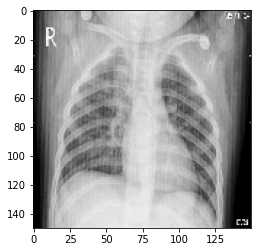

In [11]:
# ej. de radiografia
plt.imshow(x_train[0], cmap='gray')

## Model

El modelo comienza con Data Augmentation, donde las se generan mas imagenes a partir de las existentes, para así disminuir el desbalanceo en los datos.

In [12]:
# Aumento del dataset para no sesgar por desbalance
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True
)

In [13]:
# Guardado del mejor modelo (en funcion de val_accuracy) en medio del entrenamiento
checkpoint = ModelCheckpoint('mejor_modelo.hdf5', 
                             verbose=1, 
                             save_best_only=True, 
                             monitor='val_accuracy'
)

In [14]:
# Tamaño de filtro y tamaño de tasa de aprendizaje
base_filtros = 32
w_regularizers = 1e-4

In [15]:
# Arquitectura neuronal
model = Sequential()

model.add(Conv2D(base_filtros,   (3,3), padding='same', strides=(1,1), kernel_regularizer=regularizers.l2(w_regularizers), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4,4)))


model.add(Conv2D(2*base_filtros, (3,3), padding='same', strides=(1,1), kernel_regularizer=regularizers.l2(w_regularizers)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 64)        2

2022-01-18 21:47:24.550417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 21:47:24.699681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 21:47:24.700407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 21:47:24.701576: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
# Compilacion del modelo con función de perdida categorical_crossentropy y optimizador adam
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy']
)

In [17]:
# ajuste en 150 epocas utilizando 40 imagenes por epoca y guardando el mejor modelo. Ademas utilizando funcion datagen definida anteriormente.
hist = model.fit(datagen.flow(x_train, y_train),
                 callbacks=[checkpoint],
                 steps_per_epoch=40,
                 epochs=150,
                 verbose=2,
                 validation_data=(datagen.flow(x_val, y_val))
)

2022-01-18 21:47:27.644814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-01-18 21:47:29.241602: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


40/40 - 10s - loss: 0.8529 - accuracy: 0.7891 - val_loss: 0.5328 - val_accuracy: 0.7577

Epoch 00001: val_accuracy improved from -inf to 0.75769, saving model to mejor_modelo.hdf5
Epoch 2/150
40/40 - 3s - loss: 0.6229 - accuracy: 0.8453 - val_loss: 0.5416 - val_accuracy: 0.7577

Epoch 00002: val_accuracy did not improve from 0.75769
Epoch 3/150
40/40 - 3s - loss: 0.4799 - accuracy: 0.8781 - val_loss: 0.4673 - val_accuracy: 0.7577

Epoch 00003: val_accuracy did not improve from 0.75769
Epoch 4/150
40/40 - 3s - loss: 0.4699 - accuracy: 0.8797 - val_loss: 0.4181 - val_accuracy: 0.7712

Epoch 00004: val_accuracy improved from 0.75769 to 0.77115, saving model to mejor_modelo.hdf5
Epoch 5/150
40/40 - 3s - loss: 0.4798 - accuracy: 0.8852 - val_loss: 0.4528 - val_accuracy: 0.7615

Epoch 00005: val_accuracy did not improve from 0.77115
Epoch 6/150
40/40 - 3s - loss: 0.3852 - accuracy: 0.9055 - val_loss: 0.9651 - val_accuracy: 0.7577

Epoch 00006: val_accuracy did not improve from 0.77115
Epoch 

Este grafico muestra la evolucion del entrenamiento

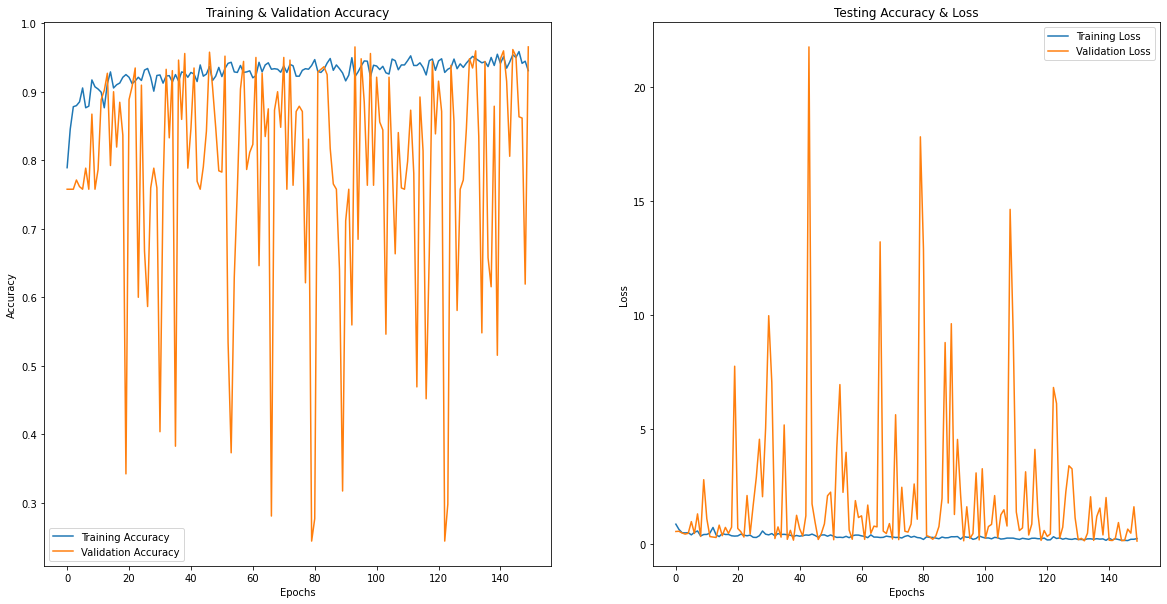

In [18]:
# Grafica de entrenamiento
epochs = [i for i in range(150)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs, hist.history['accuracy'],     label='Training Accuracy')
ax[0].plot(epochs, hist.history['val_accuracy'], label= 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, hist.history['loss'],     label = 'Training Loss')
ax[1].plot(epochs, hist.history['val_loss'], label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

Podemos ver ademas que el modelo guardado en checkpoint tiene mejor performance que el modelo resultante al final del entrenamiento.

In [19]:
# Evaluacion del modelo entrenado
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 7ms/step - loss: 0.5074 - accuracy: 0.8686
Loss of the model is -  0.5073729753494263
20/20 [==============================] - 0s 6ms/step - loss: 0.5074 - accuracy: 0.8686
Accuracy of the model is -  86.85897588729858 %


In [20]:
# Evaluacion del mejor modelo en entrenamiento
model2 = load_model('./mejor_modelo.hdf5')
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 8ms/step - loss: 0.6831 - accuracy: 0.8510
Loss of the model is -  0.6830518245697021
20/20 [==============================] - 0s 7ms/step - loss: 0.6831 - accuracy: 0.8510
Accuracy of the model is -  85.09615659713745 %


Una vision mas clara tenemos de esto al examinar la matriz de confusión

In [21]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


(624,)
(624,)


<Figure size 432x288 with 0 Axes>

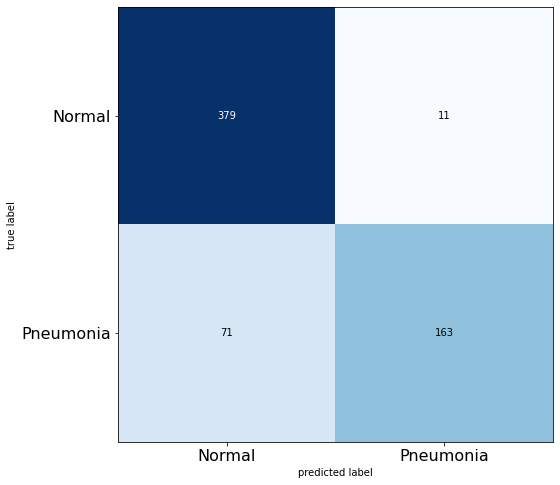

In [22]:
# Matriz de confusion para modelo entrenado
preds = model.predict(x_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

orig_test_labels = np.argmax(y_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

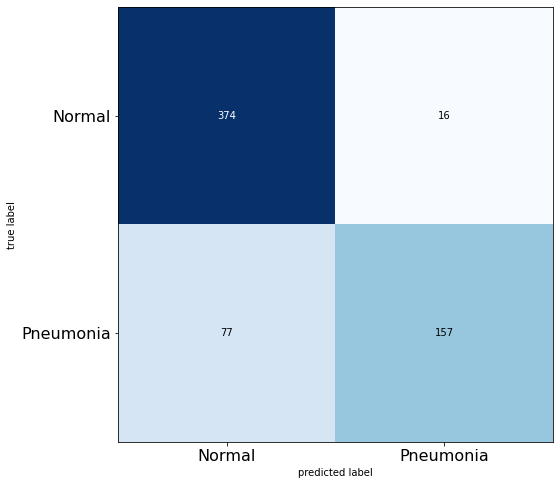

In [23]:
# Matriz de confusion para el mejor modelo guardado
preds = model2.predict(x_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

orig_test_labels = np.argmax(y_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

Aqui podemos obtener las siguientes métricas:

- accuracy: 0.873
- recall: 0.959
- especificidad: 0.731
- presición: 0.856
- valor predicho negativo: 0.914

La especificidad es el valor mas bajo obtenido, lo que indica los muchos errores que comete el algoritmo al intentar clasificar la neumonía como tal.